#### Introduction
* NHL hockey database (http://www.nhl.com/stats/)
* Statisitics of team and player performance.
* Its API is explained by Drew Hynes (https://gitlab.com/dword4/nhlapi)
* Predict playoff place based on regular season performance.

### Download data from NHL api and format into tables.

In [3]:
import numpy as np
import pandas as pd
import urllib
import json

In [122]:
# Download regular season stats, include team name, id and season
firstYear = 1989
seasonN = 31
regStats = []
for s in range(seasonN):
    season = ''.join([str(firstYear + s), str(firstYear + s + 1)])
    teamStatsUrl = "https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=" + season
    # print(teamStatsUrl)
    with urllib.request.urlopen(teamStatsUrl) as response:
        html = response.read()
        data = json.loads(html.decode())
    if len(data["teams"]) and "teamStats" in data["teams"][0]:
        for i in range(len(data["teams"])):
            teamData = data["teams"][i]["teamStats"][0]["splits"][0]["stat"]
            teamData["teamId"] = data["teams"][i]["id"]
            teamData["name"] = data["teams"][i]["name"]
            teamData["season"] = season
            # td = pd.DataFrame(np.array(list(teamData.values())).reshape(1, -1), columns = list(teamData.keys()))
            regStats.append(teamData)
regStats = pd.DataFrame(regStats)
# regStats.reset_index(inplace = True, drop = True)
# Convert to float for some features
regStats["ptPctg"] = regStats["ptPctg"].astype(float)
regStats["powerPlayPercentage"] = regStats["powerPlayPercentage"].astype(float)
regStats["faceOffWinPercentage"] = regStats["faceOffWinPercentage"].astype(float)

In [138]:
regStats.head()

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,...,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,teamId,name,season
0,80,12,61,0,31,19.4,3.000,5.088,0.9286,18.9,...,0.115,0.0,0.0,0.0,0.0,10.4,0.852,32,Quebec Nordiques,19891990
1,80,37,32,0,85,53.1,3.725,3.625,1.1429,18.7,...,0.500,0.0,0.0,0.0,0.0,12.3,0.878,33,Winnipeg Jets (1979),19891990
2,80,37,34,0,83,51.9,3.688,3.600,1.2314,19.0,...,0.450,0.0,0.0,0.0,0.0,12.0,0.883,1,New Jersey Devils,19891990
3,80,38,33,0,85,53.1,3.438,3.350,1.0889,20.1,...,0.484,0.0,0.0,0.0,0.0,12.1,0.874,34,Hartford Whalers,19891990
4,80,31,38,0,73,45.6,3.513,3.600,1.1786,23.6,...,0.389,0.0,0.0,0.0,0.0,11.9,0.893,2,New York Islanders,19891990


In [131]:
# Downdload playoff place data as the furthest round a team made.
# 0 for teams that didn't make to the playoffs and champion is labeled 5.
firstYear = 1989
seasonN = 31
places = []
for s in range(seasonN):
    season = ''.join([str(firstYear + s), str(firstYear + s + 1)])
    tournamentUrl = "https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=" + season
    # Copy team id from regular season data
    if not any(regStats["season"] == season):
        continue
    placeData = regStats.loc[regStats["season"] == season, ["season", "teamId"]]
    placeData["place"] = 0
    placeData.set_index("teamId", inplace = True)
    print(tournamentUrl)
    with urllib.request.urlopen(tournamentUrl) as response:
        html = response.read()
        data = json.loads(html.decode())
    for r in range(len(data["rounds"])):
        for s in range(len(data["rounds"][r]["series"])):
            for t in range(len(data["rounds"][r]["series"][s]["matchupTeams"])):
                td = data["rounds"][r]["series"][s]["matchupTeams"][t]
                if r == 0:
                    placeData.loc[td["team"]["id"], "place"] += 1
                if td["seed"]["isTop"]:
                    placeData.loc[td["team"]["id"], "place"] += 1
    places.append(placeData)
places = pd.concat(places)
places.reset_index(inplace = True)         

https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19891990
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19901991
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19911992
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19921993
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19931994
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19941995
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19951996
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19961997
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19971998
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.series&season=19981999
https://statsapi.web.nhl.com/api/v1/tournaments/playoffs?expand=round.

In [132]:
places.shape

(846, 3)

In [134]:
# Merge the feature data and label data
nhlData = regStats.merge(places, on = ["teamId", "season"])

In [136]:
nhlData.head()

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,...,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,teamId,name,season,place
0,80,12,61,0,31,19.4,3.000,5.088,0.9286,18.9,...,0.0,0.0,0.0,0.0,10.4,0.852,32,Quebec Nordiques,19891990,0
1,80,37,32,0,85,53.1,3.725,3.625,1.1429,18.7,...,0.0,0.0,0.0,0.0,12.3,0.878,33,Winnipeg Jets (1979),19891990,1
2,80,37,34,0,83,51.9,3.688,3.600,1.2314,19.0,...,0.0,0.0,0.0,0.0,12.0,0.883,1,New Jersey Devils,19891990,2
3,80,38,33,0,85,53.1,3.438,3.350,1.0889,20.1,...,0.0,0.0,0.0,0.0,12.1,0.874,34,Hartford Whalers,19891990,1
4,80,31,38,0,73,45.6,3.513,3.600,1.1786,23.6,...,0.0,0.0,0.0,0.0,11.9,0.893,2,New York Islanders,19891990,1


### Exploratory analysis

In [222]:
# remove data of teams that didn't made playoffs
nhlDataS = nhlData.loc[nhlData["place"] > 0].copy()
nhlDataS.shape

(488, 32)

#### Correlation between regular season points per game and playoff place
* Plot strip plots of points against place
* ANOVA test for regular season points with teams grouped by playoff place

In [241]:
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as scipy
import statsmodels.stats.multicomp as multicomp
plt.rcParams.update({"font.size": 20})

In [223]:
# Normalize ponits by number of games played
nhlDataS["ptsNorm"] = nhlDataS["pts"] / nhlDataS["gamesPlayed"]

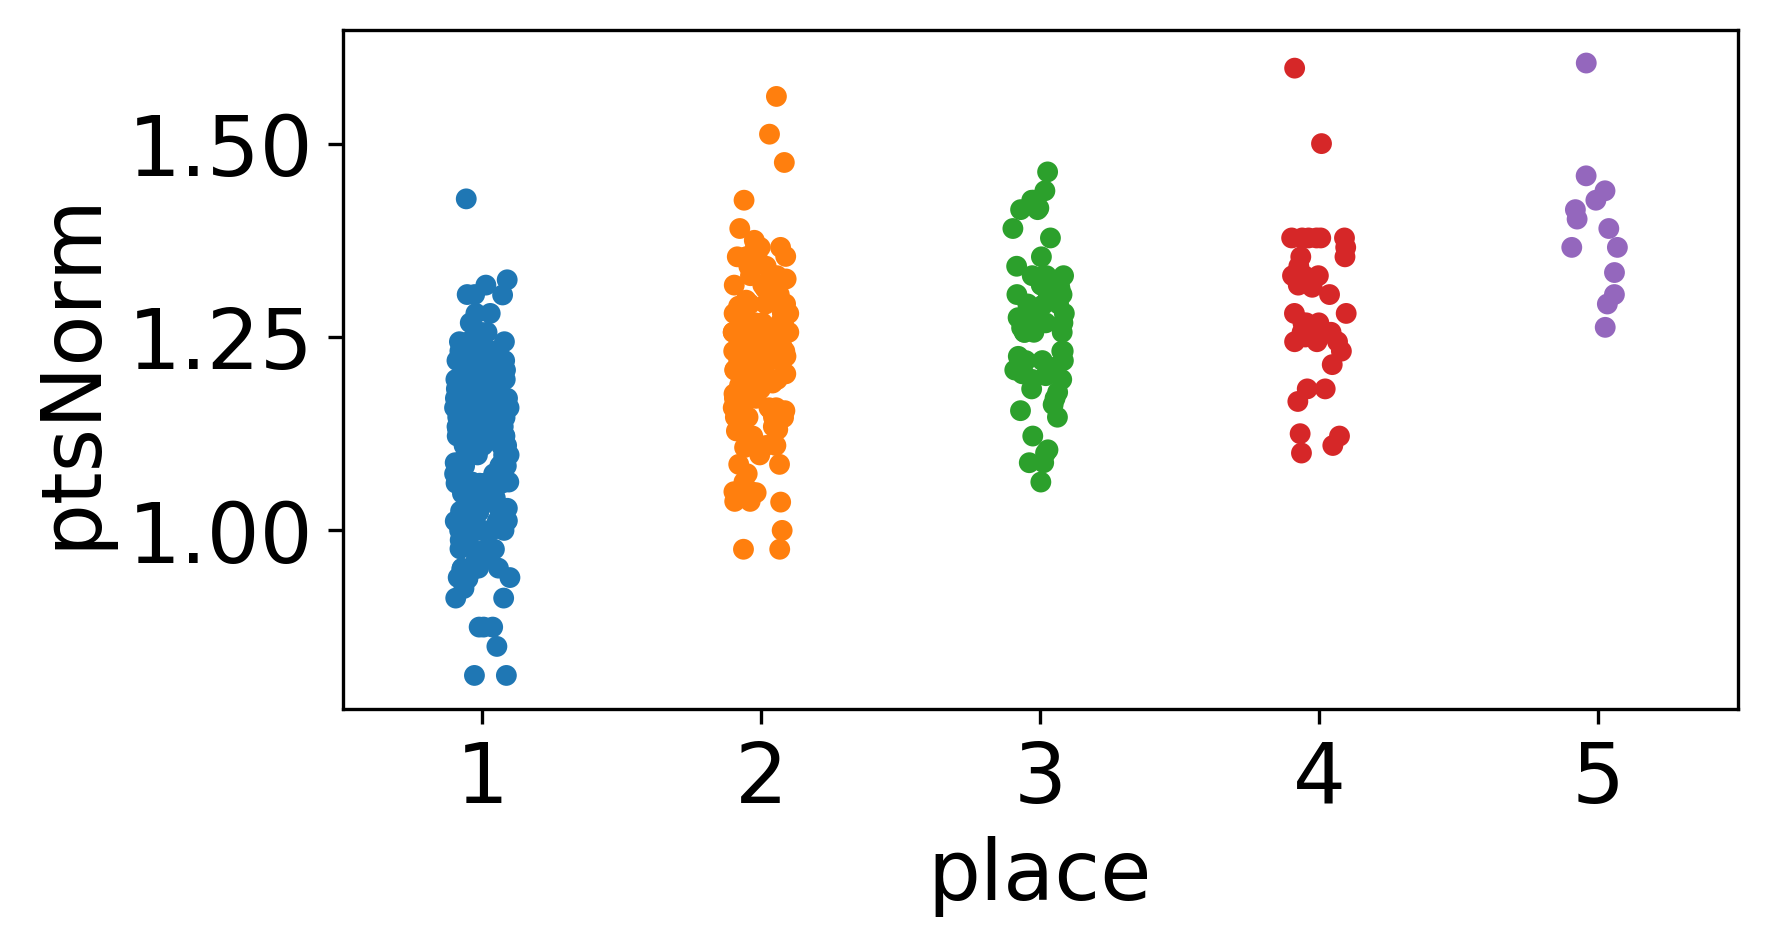

In [253]:
# Plot strip plot
plt.figure(figsize=(6, 3), dpi = 300)
sb.stripplot(x = "place", y = "ptsNorm", data = nhlDataS)

In [155]:
# ANOVA test to test whether teams with different final place have significant different 
groupedData = [nhlDataS["ptsNorm"][nhlDataS["place"] == d + 1] for d in range(5)]
print(scipy.stats.f_oneway(*groupedData))
# Post hoc pairwise comparison
result = multicomp.pairwise_tukeyhsd(nhlDataS["ptsNorm"], nhlDataS["place"])
print(result)

F_onewayResult(statistic=71.46786892673015, pvalue=1.5761436379277663e-47)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.112  0.001  0.0837 0.1403   True
     1      3   0.1504  0.001  0.1125 0.1884   True
     1      4   0.1746  0.001  0.1287 0.2206   True
     1      5   0.2744  0.001  0.1981 0.3508   True
     2      3   0.0384 0.0657 -0.0015 0.0784  False
     2      4   0.0626 0.0032   0.015 0.1102   True
     2      5   0.1624  0.001  0.0851 0.2398   True
     3      4   0.0242 0.7082 -0.0297 0.0781  False
     3      5    0.124  0.001  0.0427 0.2054   True
     4      5   0.0998 0.0126  0.0145 0.1852   True
---------------------------------------------------


#### Visualize features by performing PCA
* Rearrange the features
* Perform PCA on the features and plot them in a 2D plot

In [ ]:
from sklearn.decomposition import PCA

In [224]:
# Rearrange the regular season performance stats
# Normalize win/loss/overtime number
nhlDataS["winRate"] = nhlDataS["wins"] / nhlDataS["gamesPlayed"]
nhlDataS["loseRate"] = nhlDataS["losses"] / nhlDataS["gamesPlayed"]
nhlDataS["powerPlayGoalsPerGame"] = nhlDataS["powerPlayGoals"] / nhlDataS["gamesPlayed"]
nhlDataS["powerPlayGoalsAgainstPerGame"] = nhlDataS["powerPlayGoalsAgainst"] / nhlDataS["gamesPlayed"]
nhlDataS["powerPlayOpportunitiesPerGame"] = nhlDataS["powerPlayOpportunities"] / nhlDataS["gamesPlayed"]

# Remove team name, season, some duplicate informations and label to get feature matrix
dupF = ["gamesPlayed", "pts", "wins", "losses", "ot", "powerPlayGoals", "powerPlayGoalsAgainst"] + \
    ["powerPlayOpportunities", "faceOffsTaken", "faceOffsWon", "faceOffsLost", "faceOffWinPercentage"] + \
    ["name", "season", "place", "teamId"]
featureM = nhlDataS.drop(dupF, axis = 1, inplace = False)

In [225]:
featureM.shape

(488, 22)

In [226]:
# PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(featureM.to_numpy())

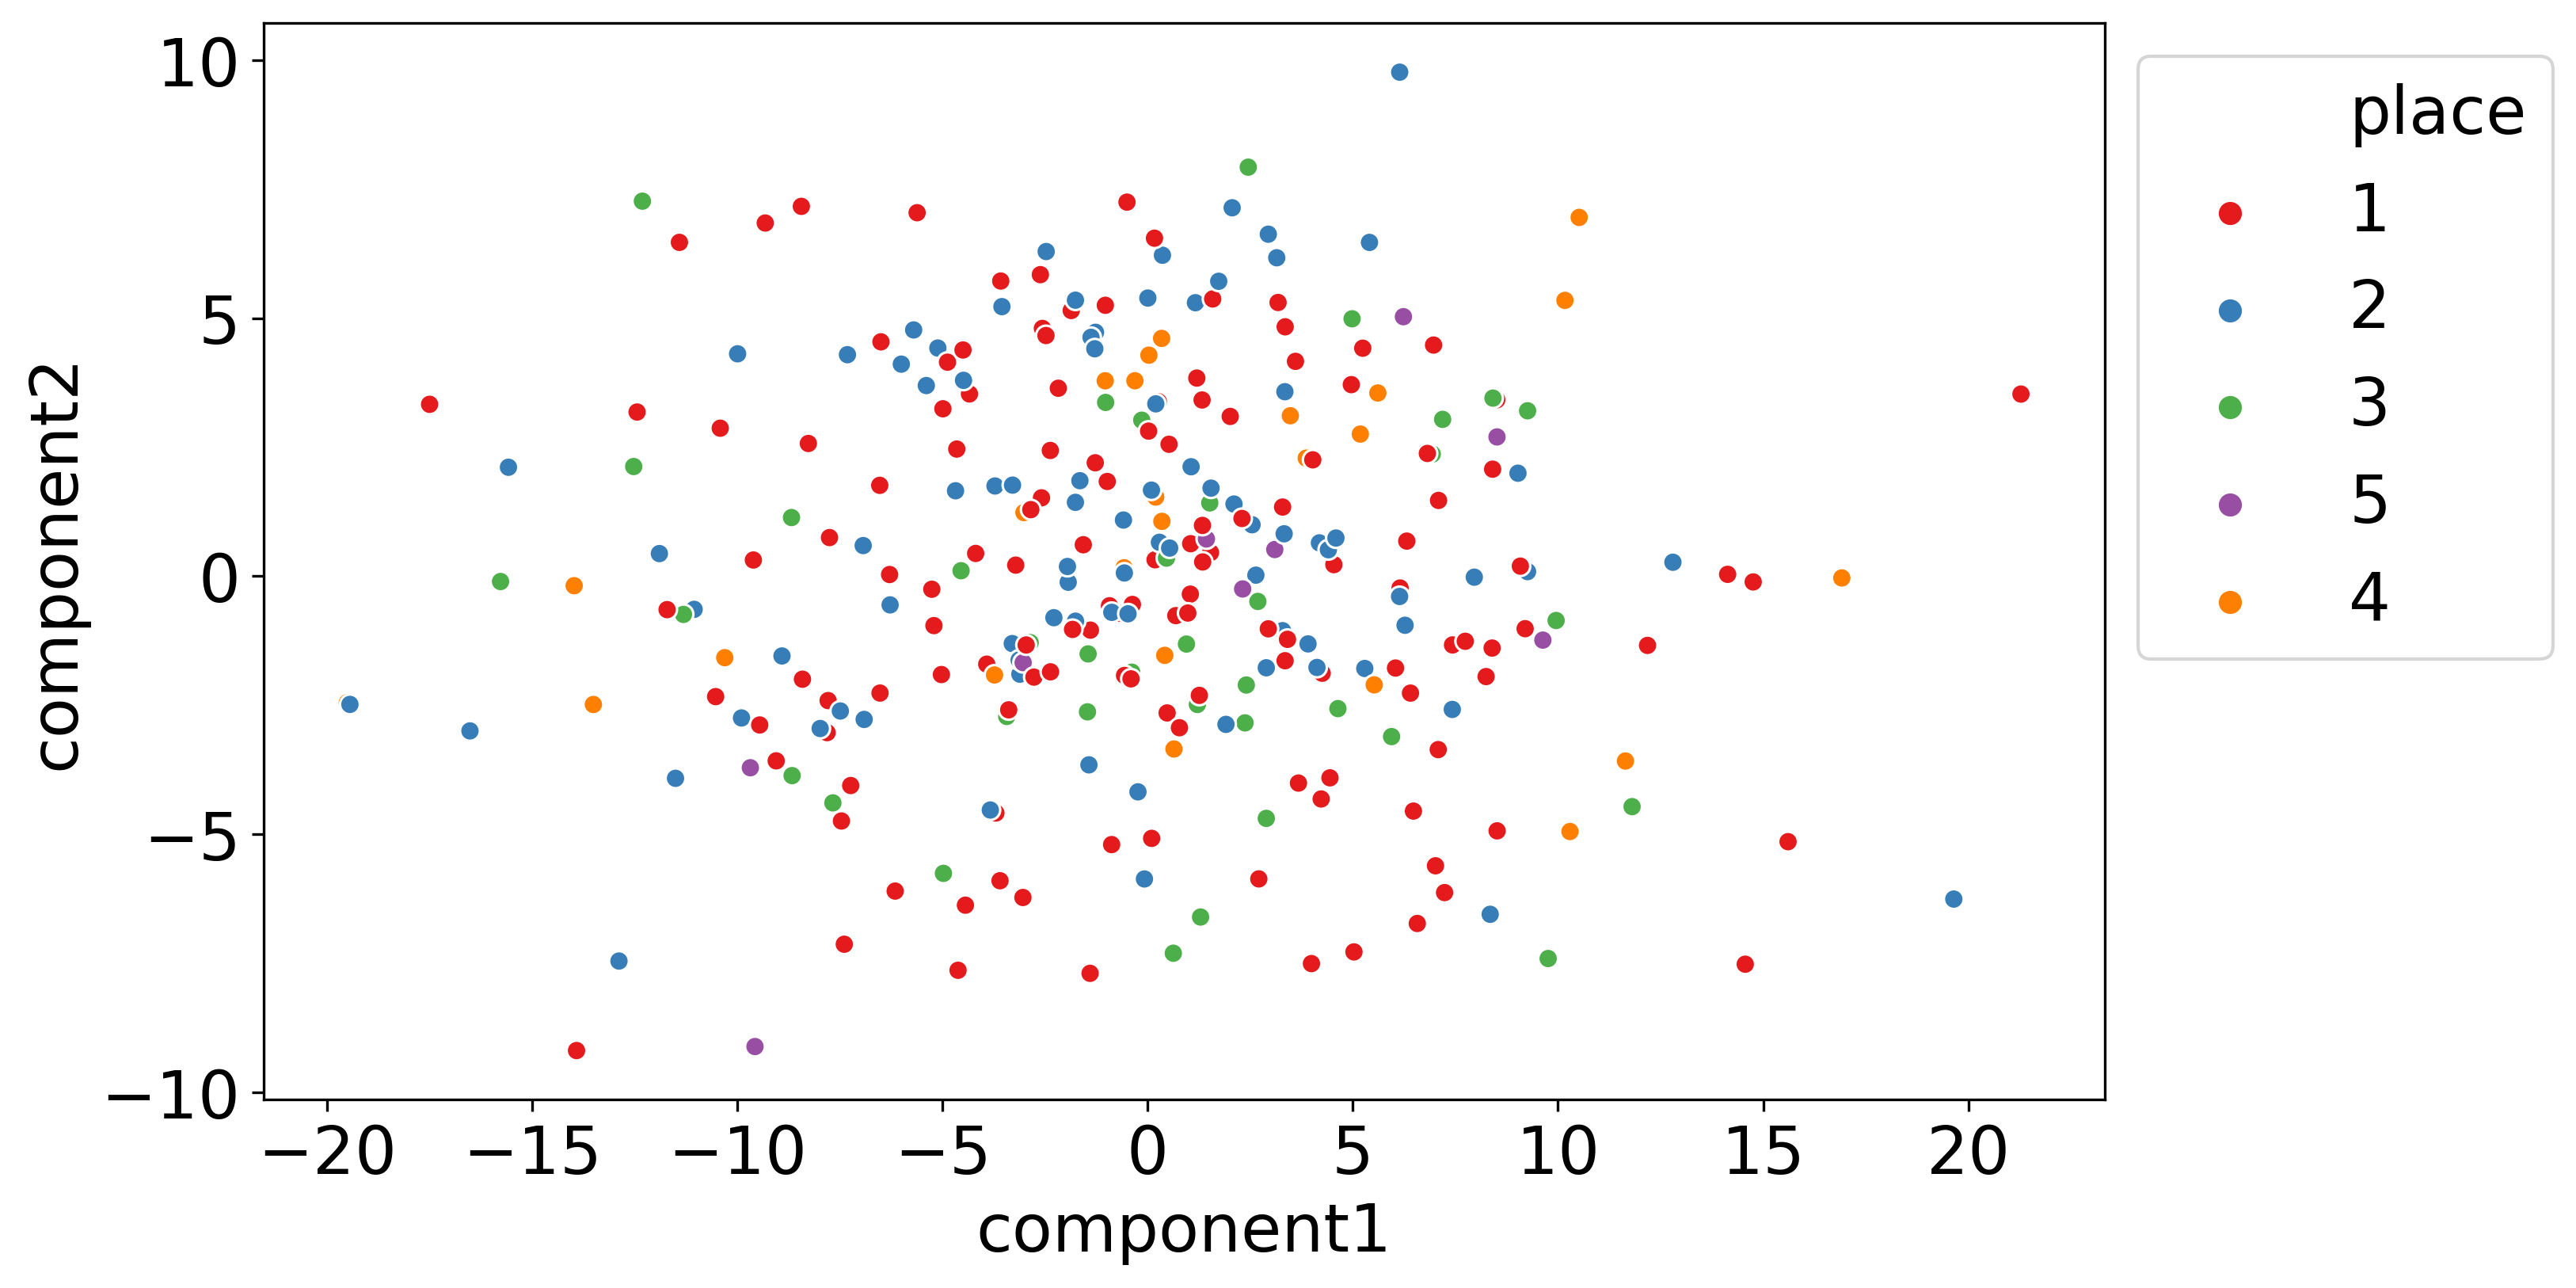

In [245]:
# Plot the data labeled with playoff places
reducedWLabel = pd.DataFrame(reduced, columns = ["component1", "component2"])
reducedWLabel["place"] = nhlDataS["place"].astype("str")
plt.figure(figsize=(10, 6), dpi = 300)
sb.scatterplot(data = reducedWLabel, x = "component1", y = "component2", hue = "place",
              palette=sb.color_palette("Set1", reducedWLabel["place"].nunique()))
plt.legend(bbox_to_anchor = (1, 1))

## Predict game results based on team and player seasonal performance
### Code used to download and format data
Include games in regular seasons from season 19971998, when time on ice data is started to be recorded. 
For each game, predict the winning team for each game using the stats of the teams in that season and 
the stats of the players in that season. For player's stats, group by skaters and goalies. In each group,
average the stats weighted by time on ice for the player.

In [9]:
# List of regular season and pre-season game ids, with home and guest team id.
firstYear = 1997
seasonN = 23
gameInfo = []
for s in range(seasonN):
    season = ''.join([str(firstYear + s), str(firstYear + s + 1)])
    scheduleUrl = "https://statsapi.web.nhl.com/api/v1/schedule?gameType=PR,R&season=" + season
    # print(scheduleUrl)
    with urllib.request.urlopen(scheduleUrl) as response:
        html = response.read()
        data = json.loads(html.decode())
    for dataOnDay in data["dates"]:
        date = dataOnDay["date"]
        for game in dataOnDay["games"]:
            gameData = {}
            gameData["id"] = game["gamePk"]
            gameData["awayId"] = game["teams"]["away"]["team"]["id"]
            gameData["awayName"] = game["teams"]["away"]["team"]["name"]
            gameData["homeId"] = game["teams"]["home"]["team"]["id"]
            gameData["homeName"] = game["teams"]["home"]["team"]["name"]
            gameData["date"] = date
            gameData["season"] = season
            gameInfo.append(gameData)
gameInfo = pd.DataFrame(gameInfo)
gameInfo.to_csv("gameInfo.csv", index = False)

In [10]:
# Download results (home_win - 0, away_win - 1 or overtime - 2) and goals (home and away) for
# each game.
gameResult = []
for gameId in gameInfo["id"]:
    gameUrl = "https://statsapi.web.nhl.com/api/v1/game/" + str(gameId) + "/linescore"
    with urllib.request.urlopen(gameUrl) as response:
        html = response.read()
        data = json.loads(html.decode())
    result = {}
    result["id"] = gameId
    result["homeGoals"] = data["teams"]["home"]["goals"]
    result["awayGoals"] = data["teams"]["away"]["goals"]
    if data["currentPeriod"] == 4:
        result["result"] = 2
    elif result["homeGoals"] > result["awayGoals"]:
        result["result"] = 0
    else:
        result["result"] = 1
    gameResult.append(result)
gameResult = pd.DataFrame(gameResult)
gameResult.to_csv("gameResult1.csv", index = False)

In [1]:
# Get team seasonal stats for each team as away or home team
# This could be downloaded from http://www.nhl.com/stats/
# Saved in teamAwaySeason.csv and teamHomeSeason.csv
pass

In [26]:
# Get player id for each of the games as away and home players
# Save in a dictionary, levels are season, game, player ids
gamePlayers = {}
gamePlayers["awaySkaters"] = {}
gamePlayers["awayGoalies"] = {}
gamePlayers["homeSkaters"] = {}
gamePlayers["homeGoalies"] = {}
for i in gameInfo.index:
    gameId = gameInfo.loc[i, "id"]
    season = gameInfo.loc[i, "season"]
    if season not in gamePlayers["homeSkaters"]:
        gamePlayers["homeSkaters"][season] = {}
        gamePlayers["homeGoalies"][season] = {}
        gamePlayers["awaySkaters"][season] = {}
        gamePlayers["awayGoalies"][season] = {}
    gameUrl = "https://statsapi.web.nhl.com/api/v1/game/" + str(gameId) + "/boxscore"
    with urllib.request.urlopen(gameUrl) as response:
        html = response.read()
        data = json.loads(html.decode())
    gamePlayers["awaySkaters"][season][gameId] = \
        list(set(data["teams"]["away"]["skaters"]) - set(data["teams"]["away"]["scratches"]))
    gamePlayers["awayGoalies"][season][gameId] = data["teams"]["away"]["goalies"]
    gamePlayers["homeSkaters"][season][gameId] = \
        list(set(data["teams"]["home"]["skaters"]) - set(data["teams"]["home"]["scratches"]))
    gamePlayers["homeGoalies"][season][gameId] = data["teams"]["home"]["goalies"]
output = json.dumps(gamePlayers)
with open("playIds.txt", 'w') as f:
    f.write(output)

KeyboardInterrupt: 

In [ ]:
# Download player seasonal stats as away or home team
firstYear = 1997
seasonN = 1
awayStats = []
homeStats = []
for s in range(seasonN):
    season = ''.join([str(firstYear + s), str(firstYear + s + 1)])
    players = []
    for playerType in gamePlayers:
        for pids = gamePlayers[playerType][season].values():
            players += pids
    players = np.unique(players)
    for p in players:
        playerUrl = "https://statsapi.web.nhl.com/api/v1/people/" + \
            str(p) + "/stats?stats=homeAndAway&&season=" + season
        with urllib.request.urlopen(playerUrl) as response:
            html = response.read()
            data = json.loads(html.decode())
        homes = data["stats"][0]["splits"][0]["stat"]
        homes["id"] = p
        homes["season"] = season
        aways = data["stats"][0]["splits"][1]["stat"]
        aways["id"] = p
        aways["season"] = season
        homeStats.append(homes)
        awayStats.append(aways)
awayStats = pd.DataFrame(awayStats)
homeStats = pd.DataFrame(homeStats)
awayStats.to_csv("playerAwayStats.csv")
homeStats.to_csv("playerHomeStats.csv")